In [4]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from os import listdir
from os.path import join,isfile
import random
import pandas as pd
from scipy import stats

In [5]:
splitData = 0.1
myPath = r'C:\Users\Ashu\Desktop\Git\papers\eeg_csv'
onlyfile = [join(myPath,f) for f in listdir(myPath) if isfile(join(myPath,f))]
random.shuffle(onlyfile)
splitData = int(splitData*len(onlyfile))
trainPath,testPath = onlyfile[splitData:],onlyfile[:splitData]

In [6]:
trainData = pd.read_csv(trainPath[0])#pd.concat((pd.read_csv(filePath) for filePath in trainPath),ignore_index=True)
testData = pd.read_csv(testPath[0])#pd.concat((pd.read_csv(filePath) for filePath in testPath),ignore_index=True)

In [7]:
trainData.columns

Index(['EEG Fp1', 'EEG Fp2', 'EEG F3', 'EEG F4', 'EEG F7', 'EEG F8', 'EEG T3',
       'EEG T4', 'EEG C3', 'EEG C4', 'EEG T5', 'EEG T6', 'EEG P3', 'EEG P4',
       'EEG O1', 'EEG O2', 'EEG Fz', 'EEG Cz', 'EEG Pz', 'EEG A2-A1',
       'ECG ECG', 'Action'],
      dtype='object')

In [8]:
trainData = trainData[['EEG Fp1','Action']]
testData = testData[['EEG Fp1','Action']]

In [10]:
from tensorflow import keras
from keras import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [11]:
#https://github.com/ni79ls/har-keras-cnn
def create_segments_and_labels(df, time_steps, step, label_name):
    # x, y, z acceleration as features
    N_FEATURES = 1
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['EEG Fp1'].values[i: i + time_steps]
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

In [12]:
time_window_size =5000
xTrain,yTrain = create_segments_and_labels(trainData,time_window_size,1,'Action')
xTest,yTest = create_segments_and_labels(testData,time_window_size,1,'Action')

In [ ]:
xTrain,yTrain = trainData['EEG Fp1'].values,trainData['Action'].values
xTest,yTest = testData['EEG Fp1'].values,testData['Action'].values

In [ ]:
xTrain = xTrain.reshape((xTrain.shape[0],1,1))
xTest = xTest.reshape((xTest.shape[0],1,1))
yTrain = yTrain.reshape((len(yTrain),1))
yTest = yTest.reshape((len(yTest),1))

In [13]:
xTrain.shape,xTest.shape

((26000, 5000, 1), (86000, 5000, 1))

In [14]:
time_window_size =5000
model = Sequential(name='EEG')
model.add(Input(shape=(time_window_size,1),name='Input'))
model.add(Conv1D(filters=16,kernel_size=5,activation='relu',name='Layer1'))
model.add(Conv1D(filters=32,kernel_size=5,activation='relu',name='Layer2'))
model.add(MaxPooling1D(pool_size=2,strides=2,name='Maxpool1d'))
model.add(Flatten(name='Flatten'))
model.add(Dense(1,activation='sigmoid',name='Output'))
model.summary()

Model: "EEG"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Layer1 (Conv1D)              (None, 4996, 16)          96        
_________________________________________________________________
Layer2 (Conv1D)              (None, 4992, 32)          2592      
_________________________________________________________________
Maxpool1d (MaxPooling1D)     (None, 2496, 32)          0         
_________________________________________________________________
Flatten (Flatten)            (None, 79872)             0         
_________________________________________________________________
Output (Dense)               (None, 1)                 79873     
Total params: 82,561
Trainable params: 82,561
Non-trainable params: 0
_________________________________________________________________


In [15]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [26]:
optimizer = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss=tf.keras.losses.BinaryCrossentropy(),metrics=['accuracy'])
history = model.fit(xTrain,yTrain,
                    batch_size=20,
                    epochs=20,verbose=1,
                    validation_data=(xTest,yTest)
                   )

Epoch 1/20
1300/1300 [==============================] - 176s 136ms/step - loss: 3.2316e-10 - accuracy: 1.0000 - val_loss: 21.8517 - val_accuracy: 0.0000e+00
Epoch 2/20
1300/1300 [==============================] - 179s 138ms/step - loss: 3.2316e-10 - accuracy: 1.0000 - val_loss: 21.8517 - val_accuracy: 0.0000e+00
Epoch 3/20
1300/1300 [==============================] - 174s 134ms/step - loss: 3.2316e-10 - accuracy: 1.0000 - val_loss: 21.8517 - val_accuracy: 0.0000e+00
Epoch 5/20
1300/1300 [==============================] - 175s 135ms/step - loss: 3.2316e-10 - accuracy: 1.0000 - val_loss: 21.8517 - val_accuracy: 0.0000e+00
Epoch 6/20
1300/1300 [==============================] - 149s 114ms/step - loss: 3.2316e-10 - accuracy: 1.0000 - val_loss: 21.8517 - val_accuracy: 0.0000e+00
Epoch 7/20
1300/1300 [==============================] - 132s 102ms/step - loss: 3.2316e-10 - accuracy: 1.0000 - val_loss: 21.8517 - val_accuracy: 0.0000e+00
Epoch 8/20
1300/1300 [==============================] - 17

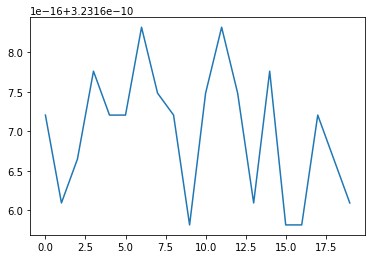

In [27]:
plt.plot(history.history['loss'])
plt.show()

In [29]:
trainData

,EEG Fp1,Action
0,3.525820e-06,1
1,2.577400e-06,1
2,9.584053e-07,1
3,-9.758388e-07,1
4,-2.584147e-06,1
...,...,...
30995,-7.019216e-10,1
30996,-7.019216e-10,1
30997,-7.019216e-10,1
30998,-7.019216e-10,1
